In [78]:
import pandas as pd

cycling = pd.read_csv("../datasets/bike_rides.csv", index_col=0,
                      parse_dates=True)
cycling.index.name = ""
target_name = "power"
data, target = cycling.drop(columns=target_name), cycling[target_name]
data

,heart-rate,cadence,speed,acceleration,slope
,,,,,
2020-08-18 14:43:19,102.0,64.0,4.325,0.0880,-0.033870
2020-08-18 14:43:20,103.0,64.0,4.336,0.0842,-0.033571
2020-08-18 14:43:21,105.0,66.0,4.409,0.0234,-0.033223
2020-08-18 14:43:22,106.0,66.0,4.445,0.0016,-0.032908
2020-08-18 14:43:23,106.0,67.0,4.441,0.1144,0.000000
...,...,...,...,...,...
2020-09-13 14:55:57,130.0,0.0,1.054,0.0234,0.000000
2020-09-13 14:55:58,130.0,0.0,0.829,0.0258,0.000000
2020-09-13 14:55:59,129.0,0.0,0.616,-0.1686,0.000000


In [79]:
import numpy as np

speed_cubed = data['speed'] **3
sin_slope_angle = data['slope'].apply(lambda x:np.sin(np.arctan(x)))
speed_sin_angle = data['speed'] *sin_slope_angle

In [80]:
acceleration = data['acceleration'].apply(lambda x:0 if x<0 else x)
speed_acceleration = data['speed'] *acceleration

In [81]:
data_matrix = pd.concat([speed_cubed, data['speed'], speed_sin_angle, speed_acceleration], axis=1)
data_matrix.columns = ['speed^3', 'speed', 'speed*sin(alpha)', 'speed*accel']

In [82]:
data_matrix

,speed^3,speed,speed*sin(alpha),speed*accel
,,,,
2020-08-18 14:43:19,80.901828,4.325,-0.146402,0.380600
2020-08-18 14:43:20,81.520685,4.336,-0.145482,0.365091
2020-08-18 14:43:21,85.707790,4.409,-0.146398,0.103171
2020-08-18 14:43:22,87.824421,4.445,-0.146198,0.007112
2020-08-18 14:43:23,87.587538,4.441,0.000000,0.508050
...,...,...,...,...
2020-09-13 14:55:57,1.170905,1.054,0.000000,0.024664
2020-09-13 14:55:58,0.569723,0.829,0.000000,0.021388
2020-09-13 14:55:59,0.233745,0.616,0.000000,0.000000


In [83]:
from sklearn.linear_model import RidgeCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import ShuffleSplit, cross_validate
from sklearn.pipeline import make_pipeline

cv= ShuffleSplit(n_splits=4)
model = make_pipeline(StandardScaler(), RidgeCV())

cv_results_lin = cross_validate(model, data_matrix, target,cv=cv, scoring = 'neg_mean_absolute_error', return_estimator=True, return_train_score=True)

cv_results_lin

{'fit_time': array([0.0383718 , 0.03720737, 0.03059316, 0.03034925]),
 'score_time': array([0.00481105, 0.00376701, 0.00351024, 0.00340843]),
 'estimator': [Pipeline(steps=[('standardscaler', StandardScaler()),
                  ('ridgecv', RidgeCV(alphas=array([ 0.1,  1. , 10. ])))]),
  Pipeline(steps=[('standardscaler', StandardScaler()),
                  ('ridgecv', RidgeCV(alphas=array([ 0.1,  1. , 10. ])))]),
  Pipeline(steps=[('standardscaler', StandardScaler()),
                  ('ridgecv', RidgeCV(alphas=array([ 0.1,  1. , 10. ])))]),
  Pipeline(steps=[('standardscaler', StandardScaler()),
                  ('ridgecv', RidgeCV(alphas=array([ 0.1,  1. , 10. ])))])],
 'test_score': array([-73.51957674, -72.35379715, -72.44302404, -71.49032678]),
 'train_score': array([-72.36701286, -72.47751381, -72.41070785, -72.55862548])}

In [84]:
print(f"mean speed*sin(alpha): {data_matrix['speed*sin(alpha)'].mean():.4f}")

mean speed*sin(alpha): -0.0027


In [85]:
power_model_coef = pd.DataFrame([est['ridgecv'].coef_ for est in cv_results_lin['estimator']])
power_model_coef.columns = [col+"_coef" for col in data_matrix.columns]
power_model_coef

,speed^3_coef,speed_coef,speed*sin(alpha)_coef,speed*accel_coef
0,5.791515,32.988171,80.982259,11.409453
1,5.125382,33.542148,80.415942,11.180120
2,6.396024,32.402930,80.774546,10.267323
3,5.867832,32.687407,80.618029,11.023592


In [86]:
from sklearn.ensemble import HistGradientBoostingRegressor

hist_model = HistGradientBoostingRegressor(max_iter=1_000, early_stopping=True)

cv= ShuffleSplit(n_splits=4)
model = make_pipeline(StandardScaler(), hist_model)

cv_results_hist = cross_validate(model, data, target,cv=cv, scoring = 'neg_mean_absolute_error', return_estimator=True, return_train_score=True)



In [87]:
print(cv_results_hist['test_score'], cv_results_hist['train_score'], sep='\n')

[-43.97473071 -44.789816   -44.68750523 -45.06420964]
[-40.53175759 -40.93705498 -41.00135863 -42.00986284]


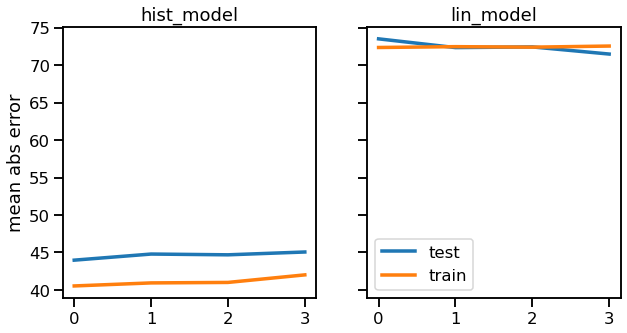

In [88]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(ncols=2, sharey=True, figsize=(10,5))

ax[0].plot(-cv_results_hist['test_score'], label='test')
ax[0].plot(-cv_results_hist['train_score'],label='train')
ax[0].set_title("hist_model")
ax[0].set_ylabel("mean abs error")

ax[1].plot(-cv_results_lin['test_score'], label='test')
ax[1].plot(-cv_results_lin['train_score'],label='train')
ax[1].set_title("lin_model")

plt.legend()

In [89]:
print(f"cycling days: {set(data.index.date)}")

cycling days: {datetime.date(2020, 8, 20), datetime.date(2020, 9, 13), datetime.date(2020, 8, 26), datetime.date(2020, 8, 18)}


In [157]:
from sklearn.model_selection import LeaveOneGroupOut

#encode bike ride dates
groups, _ =pd.factorize(data.index.date)

cv=LeaveOneGroupOut()

lin_model = make_pipeline(StandardScaler(), RidgeCV())
cv_lin_logo = cross_validate(lin_model, data_matrix, target, cv=cv, groups=groups, return_train_score=True, scoring = 'neg_mean_absolute_error')

hist_model = make_pipeline(StandardScaler(), HistGradientBoostingRegressor())
cv_hist_logo = cross_validate(hist_model, data, target, cv=cv, groups=groups, return_train_score=True, scoring = 'neg_mean_absolute_error')

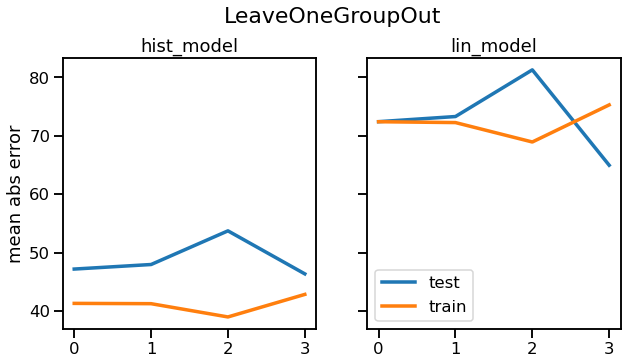

In [158]:
fig, ax = plt.subplots(ncols=2, sharey=True, figsize=(10,5))

ax[0].plot(-cv_hist_logo['test_score'], label='test')
ax[0].plot(-cv_hist_logo['train_score'],label='train')
ax[0].set_title("hist_model")
ax[0].set_ylabel("mean abs error")

ax[1].plot(-cv_lin_logo['test_score'], label='test')
ax[1].plot(-cv_lin_logo['train_score'],label='train')
ax[1].set_title("lin_model")

plt.suptitle("LeaveOneGroupOut", y=1.02)

plt.legend()

In [159]:
print(f"shuffle split mean error for linear model: {-cv_results_lin['test_score'].mean():.3f} +/- {cv_results_lin['test_score'].std():.3f}")
print(f"logo split mean error for linear model: {-cv_lin_logo['test_score'].mean():.3f} +/- {cv_lin_logo['test_score'].std():.3f}" )
print(f"shuffle split has higher MAE of {(-cv_results_lin['test_score'].mean()) - (-cv_lin_logo['test_score'].mean()):.2f} Watts ")

shuffle split mean error for linear model: 72.452 +/- 0.720
logo split mean error for linear model: 73.015 +/- 5.779
shuffle split has higher MAE of -0.56 Watts 


In [160]:
print(f"shuffle split mean error for linear model: {-cv_results_hist['test_score'].mean():.3f} +/- {cv_results_hist['test_score'].std():.3f}")
print(f"logo split mean error for linear model: {-cv_hist_logo['test_score'].mean():.3f}  +/- {cv_hist_logo['test_score'].std():.3f}")
print(f"shuffle split has higher MAE of {(-cv_results_hist['test_score'].mean()) - (-cv_hist_logo['test_score'].mean()):.2f} Watts ")

shuffle split mean error for linear model: 44.629 +/- 0.402
logo split mean error for linear model: 48.846  +/- 2.893
shuffle split has higher MAE of -4.22 Watts 


In [173]:
cv = LeaveOneGroupOut()
train_indices, test_indices = list(cv.split(data, target, groups=groups))[0]

data_linear_model_train = data_matrix.iloc[train_indices]
data_linear_model_test = data_matrix.iloc[test_indices]

data_train = data.iloc[train_indices]
data_test = data.iloc[test_indices]

target_train = target.iloc[train_indices]
target_test = target.iloc[test_indices]

In [174]:
lin_model.fit(data_linear_model_train, target_train)
lin_pred = lin_model.predict(data_linear_model_test)

hist_model.fit(data_train, target_train)
hist_pred = hist_model.predict(data_test)

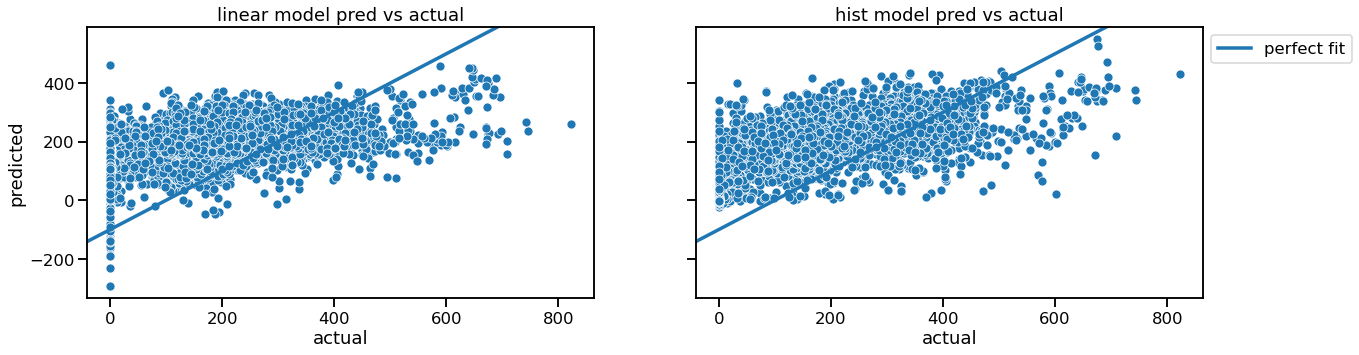

In [175]:
import seaborn as sns

fig,axs = plt.subplots(ncols=2, figsize=(20,5), sharey=True)

sns.scatterplot(x=target_test, y=lin_pred, ax=axs[0])
axs[0].axline((0,-100), slope=1, label='perfect fit')
axs[0].set_title("linear model pred vs actual")
axs[0].set_ylabel('predicted')
axs[0].set_xlabel('actual')

sns.scatterplot(x=target_test, y=hist_pred, ax=axs[1])
axs[1].axline((0,-100), slope=1, label='perfect fit')
axs[1].set_title("hist model pred vs actual")
axs[1].set_xlabel('actual')

plt.legend(bbox_to_anchor = (1,1))

In [176]:
time_slice = slice("2020-08-18 17:00:00", "2020-08-18 17:05:00")

data_test_linear_model_subset = data_linear_model_test[time_slice]
data_test_subset = data_test[time_slice]
target_test_subset = target_test[time_slice]

In [178]:
lin_pred_subset = lin_model.predict(data_test_linear_model_subset)
hist_pred_subset = hist_model.predict(data_test_subset)

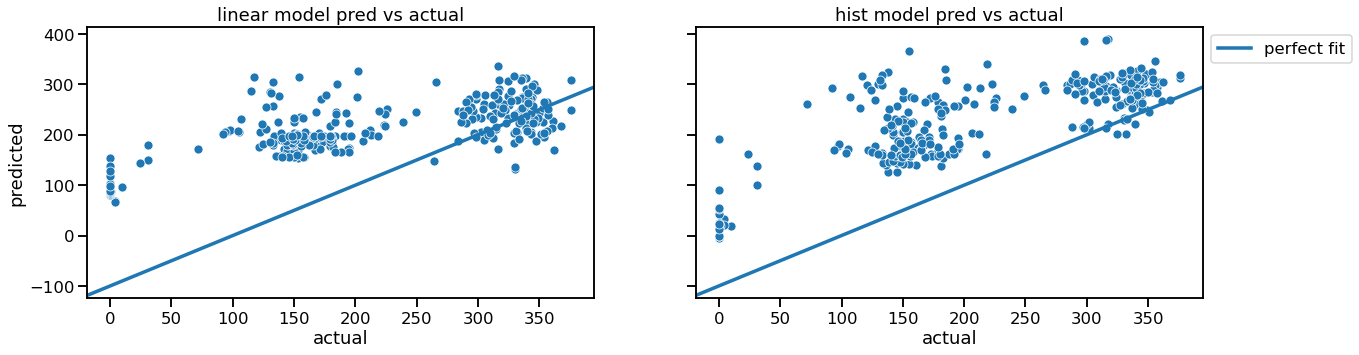

In [182]:
fig,axs = plt.subplots(ncols=2, figsize=(20,5), sharey=True)

sns.scatterplot(x=target_test_subset, y=lin_pred_subset, ax=axs[0])
axs[0].axline((0,-100), slope=1, label='perfect fit')
axs[0].set_title("linear model pred vs actual")
axs[0].set_ylabel('predicted')
axs[0].set_xlabel('actual')

sns.scatterplot(x=target_test_subset, y=hist_pred_subset, ax=axs[1])
axs[1].axline((0,-100), slope=1, label='perfect fit')
axs[1].set_title("hist model pred vs actual")
axs[1].set_xlabel('actual')

plt.legend(bbox_to_anchor = (1,1))


In [188]:
from sklearn.metrics import mean_absolute_error

print(f"hist model mae: {mean_absolute_error(target_test, hist_pred)}")
print(f"lin model mae: {mean_absolute_error(target_test, lin_pred)}")


hist model mae: 47.22626301319795
lin model mae: 72.44062969214498
